## Numeryczne Rozwiązywanie Rónań Różniczkowych Zwyczajnych
### Uniwersytet Jagielloński 2023
Katedra Teorii Optymalizacji i Sterowania UJ

In [1]:
import numpy as np
from numpy import sin, cos, exp, sqrt
import matplotlib.pyplot as plt

## Równanie różniczkowe zwyczajne rzędu 2

Każde równanie różniczkowe rzędu n można traktować jako układ równań n równań różniczkowych rzędu 1.

Rozważmy RRZ rzędu 2:

$x''(t) = f(t, x, x')$

$t \in [a, b]$   

$x(a) = \alpha, \quad x'(a) = \gamma$

Zastosujmy podstawienie: $y = x'$, wtedy:

$x'(t) = y = f_0(t, x, y)$

$y'(t) = f_1(t, x, y)$

Przechodząc na przestrzeń wektorów $R^2$ mamy dobrze znane równanie:

$𝐱'(t) = 𝐟(t, 𝐱)$

z warunkiem początkowym $𝐱(a) = (\alpha, \gamma)$.

In [85]:
def rk4(dxdt, t, x, h):
    k1 = h * dxdt(t, x[-1])
    k2 = h * dxdt(t + 0.5 * h, x[-1] + 0.5 * k1)
    k3 = h * dxdt(t + 0.5 * h, x[-1] + 0.5 * k2)
    k4 = h * dxdt(t + h, x[-1] + k3)
    return x[-1] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def initial_value_problem(f, h=0.01, a=0, b=1, alpha=0, gamma=1):
    y = [np.asarray([alpha, gamma])]
    t = [a]
    def fp(t, y):
        return np.asarray([y[1], f(t, y)])
    next_t = t[-1] + h

    #poprawione dla dokladnosci ostatniego t
    while next_t <= b + 1e-8:
        y.append(rk4(fp, t[-1], y, h))
        t.append(next_t)
        next_t += h
    return np.asarray(t), np.asarray(y)

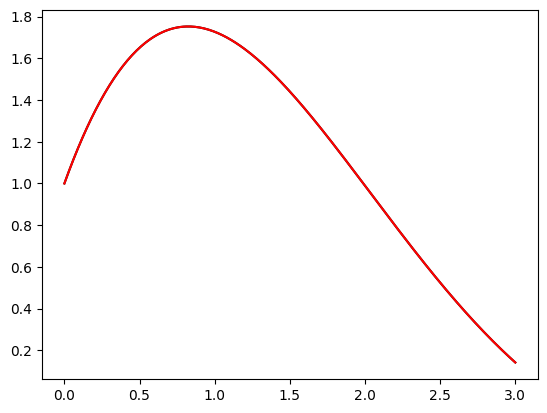

In [3]:
t, x = initial_value_problem(f=lambda t, x: -x[1] - x[0], a=0, b=3, alpha=1, gamma=2, h=0.01)
plt.plot(t, x[:, 0], color="black")
plt.plot(t, exp(-0.5 * t) * (5/sqrt(3) * sin(sqrt(3) / 2 * t) + cos(sqrt(3) / 2 * t)), color="red")

## Metoda strzałów


In [196]:
def f(t, y):
  return 400*y[0] + 400 * (np.cos(np.pi * t) ** 2) + (2 * (np.pi ** 2) * np.cos(2 * np.pi * t))

def dfdx(t, y):
  return 400

def dfdx_prime(t, y):
  return 0

def exact(t):
  return (np.exp(-20) / (1 + np.exp(-20))) * (np.exp(20 * t) + np.exp(-20 * t)) - np.cos(np.pi * t) ** 2
  #return (np.exp(-20) / (1 + np.exp(-20))) * np.exp(20 * t) + ((np.exp(-20) / (1 + np.exp(-20))) * np.exp(-20 * t)) - np.cos(np.pi * t) ** 2


#SymPy lub JAX do automatycznego rozniczkowania

#przedzial t
a = 0
b = 1

#wartosci na przedzialach
alpha = -1
gamma = 0

h = 0.01

z = 1.0

#phi(z) liczone tylko raz
_phi_cache = {}


#### Funkcja phi

In [182]:
def phi(z):
    t, y = initial_value_problem(f, h=h, a=a, b=b, alpha=alpha, gamma=z)
    _phi_cache[z] = (y[-1, 0] - gamma, t, y)
    return _phi_cache[z][0]

#### Pochodna funkcji phi

In [183]:
def d_phi(z):
    _, t, xz = _phi_cache[z]

    def first_variational_eq(t, y, x, x_prime):
        return np.asarray([
            y[1],
            dfdx(t, [x, x_prime]) * y[0] + dfdx_prime(t, [x, x_prime]) * y[1]
        ])

    # y(a) = 0, y'(a) = 1
    y = [np.asarray([0.0, 1.0])]

    for i in range(len(t) - 1):
        def fvar(t, y):
            return first_variational_eq(t, y, xz[i, 0], xz[i][1])

        y.append(rk4(fvar, t[i], y, h))

    return y[-1][0]


#### Metoda Newtona

In [184]:
def newton(function, initial_value, tol=1e-5, max_iter=10):
    z = initial_value

    for _ in range(max_iter):
        fz = function(z)
        dfz = d_phi(z)
        z_new = z - fz / dfz

        if abs(z_new - z) < tol:
            z = z_new
            break

        z = z_new

    function(z)
    _, t, xz = _phi_cache[z]
    return t, xz[:, 0]

In [185]:
t, x_shooting = newton(phi, z)


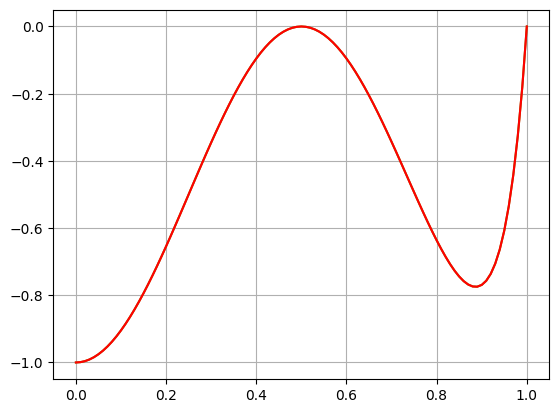

In [186]:
plt.plot(t, x_shooting, color="olive")
plt.plot(t, exact(t), color="red")
plt.grid()


## Metoda różnic skończonych


#### Konstrukcja układu równań

In [197]:
# TODO

def finite_difference(f, a, b, alpha, beta, h):
    n = int(round(b - a) / h) + 1
    t = np.linspace(a, b, n)
    A = np.zeros((n - 2, n - 2))
    b_vec = np.zeros(n - 2)

    x = np.linspace(alpha, beta, n)

    for i in range(1, n - 1):

        j = i - 1
        # schemat centralny
        x_prime = (x[i + 1] - x[i - 1]) / (2 * h)
        v = dfdx(t[i], [x[i], x_prime])
        w = dfdx_prime(t[i], [x[i], x_prime])

        if j > 0:
            A[j, j - 1] = 1 + w * h/2
        A[j, j] = -2 - v * h**2
        if j < n - 3:
            A[j, j + 1] = 1 - w * h/2

        b_vec[j] = f(t[i], [x[i], x_prime]) * h**2


    # korekta dla brzegowych
    x_prime_0 = (x[2] - x[0]) / (2 * h)
    b_vec[0] -= alpha * (1 + dfdx_prime(t[1], [x[1], x_prime_0]) * h/2)

    x_prime_last = (x[-1] - x[-3]) / (2 * h)
    b_vec[-1] -= beta * (1 - dfdx_prime(t[-2], [x[-2], x_prime_last]) * h/2)

    x_res = np.concatenate([[alpha], np.linalg.solve(A, b_vec), [beta]])

    return t, x_res



#### Rozwiązanie układu równań

In [198]:
t, x_finite_diff = finite_difference(f, a=a, b=b, alpha=alpha, beta=gamma, h=h)


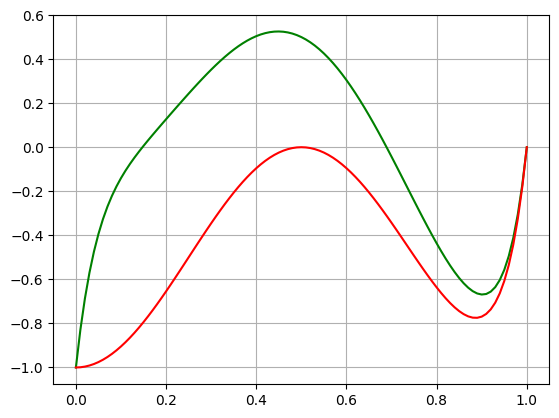

In [199]:
plt.plot(t, x_finite_diff, color="green")
plt.plot(t, exact(t), color="red")
plt.grid()


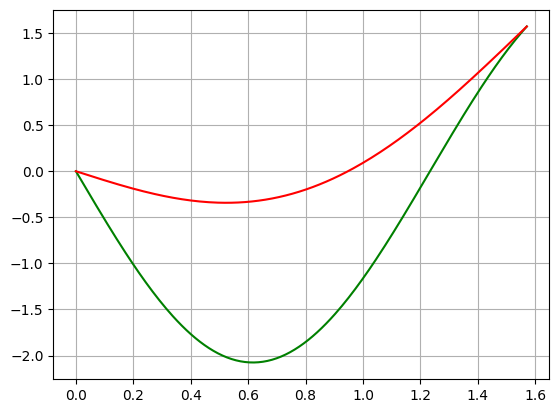

In [195]:
def f(t, y):
  return -4 * y[0] + 4 * t

def dfdx(t, y):
  return -4

def dfdx_prime(t, y):
  return 0

def exact(t):
  return t - np.sin(2*t)

a = 0
b = np.pi / 2

alpha = 0
gamma = np.pi / 2 - np.sin(np.pi)

t, x_finite_diff = finite_difference(f, a=a, b=b, alpha=alpha, beta=gamma, h=h)

plt.plot(t, x_finite_diff, color="green")
plt.plot(t, exact(t), color="red")
plt.grid()
